## Summary:
**Name:** Prepares a work pipeline for DA/ML numerical experiments  
**Author:** Siyang Jing  
**Organization:** UNC-CH  
**License:** WTFPL  

**Reference:**
1. Amit Apte's EnKF code in Python
1. Christian Sampson's EnKF code in matlab
1. Tensorflow and Keras tutorials
1. Relevant numerous papers

**Description:**  
This file prepares work pipeline framework that is suitable for a computing job on Longleaf.
1. Data generation parameters
  1. Model paramters (for Lorenz 96):
    * pars: i.e. $F$
    * noise: could potentially include stachostic flavor in model
  2. Observation parameters:
    * H, and dobs: observation operator, and dimension
    * nobs: size of data generated
    * deltaobs: step size
    * sigmaobs: noise level
    * Noise type **TODO**
2. Set up for ML:
  1. General architecture
    * Probably FNN is enough
  1. Prepare the data
    * Normalization?
    * All kinds of stuff needs to learn **TODO**
  1. Return a usable model
    * Needs to consider all types of data preparation
      * If normalized, then normalize before predict
    * What is the most efficient approach **TODO**
    * Possible linearization **TODO**
2. Choose ML parameters, including:
  1. Architecture parameters
    * Type and number of layers
    * Number of neurons
  1. Optimization parameters
    * Loss function
    * Validation split
    * EPOCHS
  1. Statistical parameters
    * What to record?
3. Choose DA parameters, includng (a lot will be the same as data generation parameters, need to figure out a better way to do this):
  1. Model parameters
    * pars
    * ferr: forecast model error
    * Different models for TM and TF **TODO**
  1. Observation parameters
    * H, and dobs: observation operator, and dimension
    * Hmat: H matrix for linear EnKF case
    * nobs: size of data generated
    * deltaobs: step size
    * sigmaobs: noise level
    * Noise type **TODO**
  1. Scheme parameters
    * infl_lin: inflation parameter for linear case
    * infl_nlin: inflation parameter for nonlinear case
    * sigmainit: initial spread
    * nens: ensemble size
4. Run the procedure, record statistics, including:
  1. 
  1. 
  1. 
  1. 
5. Draw statistical inference, including:
  1. 
  1. 
  1. 
  1. 
  1. 
6. Plotting?

**Requirements:**
1. Relevant Python modules
1. AuxFuncs, which defines the following:  
  1. Observation operator  
  1. Stupid inverse function  
  1. Lorenz96 as model
  
**Ideas for Experiment:**
1. Observation 
1. DA
  * Inflation scheme?
    * Now there seems huge error for a few certain steps
    * Potentially because of ill-condition?
    * Totally by coincidence?
  * How much observation / model error affects?
  * Can't really consider dobs,
  * Ensemble numbers
  * A really really long run to analyze the data
1. ML
  * For now the relative error is 85 percent, which is considerably good, which means we probably can for now forget about the ML experiments part. When we get to the real data, we are going to use all there are anyways, can't really consider questions like "how many data to use" or "how many epochs to train".
  * Observation error: 
    * some factors unaccounted for, like atmospheric conditions etc., 
    * causing systematic error? 
    * random noise can't simulate?
    * how to simulate?
1. Integration

## Possible functionize ideas:  _TODO_

_Input_:
* Parameters: (To be implemented)
  * ndim: dimension of state space default is 40,
  * pars: parameters for model ode, default value is (8.0) for Lorenz 96,
  * nobs: number of observations, dafault is 50,
  * deltaobs=0.1,
  * dobs=None,
  * Hmat=None,
  * sigmaobs=0.9,
  * infl_lin=0.5,
  * infl_nlin=1,
  * sigmainit=1.3,
  * nens=100,
  * ferr=1.0
* DA Flags: (To be implemented)
  * HTYPE: type of observation operator
    * None: everything is specified in parameters, **TODO**
    * 0: ObsOp_40_20
    * 1: ObsOp_40_20 with Inv_20_10
  * LINEAR: whether to use linearized KF or not, specific to $H$
  * HERROR: whether H and Hm are the same
* Usage Flags: (To be implemented)
  * PLOTTING
  * DEBUG
  * SAVEDATA: indicator for which data to save  
    * 0: Don't save anything
    * 1: Save everything including,  
      1. Flags and Parameters  
      1. xfm, xam, xfcov, xacov  
      1. yfm, yfcov  
      1. statistics  
    * 2: Flags, Paramters, Statistics (No running data)
    * 3: haha
* Experimental Setup:
  * Parameter to change and value range
  
_Output_:  
Statistics

_Saved Files_:   
1. Training data
2. ML Model
3. 


_Plots_:
1. Long true trajectory
1. Run results
1. Statistics

## TODO List

In [1]:
from EnKF_func import *
from AuxFuncs import *
from ML_func import *
from DataGenerator import *

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [ ]:
SAVEMODEL = True
SAVEMODELDIR = 'Model/'

IMPORTMODEL = False
IMPORTDIR = None

In [2]:
def build_model():
    model = keras.Sequential([
    keras.layers.Dense(20, activation=tf.nn.relu, 
                       input_shape=(train_data.shape[1],)),
    keras.layers.Dense(20, activation=tf.nn.relu),
    keras.layers.Dense(20)
    ])

    #optimizer = tf.train.RMSPropOptimizer(0.001)

    model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae','acc'])
    return model

In [3]:
def PrepareData(X,Y):
    
    data_size = np.shape(X)[0]

    # Shuffle the input
    order = np.argsort(np.random.random(data_size))

    train_size = round(data_size * 0.8)
    test_size = data_size - train_size

    train_data = X[order[0:train_size],:]
    train_labels = Y[order[0:train_size],:]

    test_data = X[order[train_size:],:]
    test_labels = Y[order[train_size:],:]


    ## Normalize the data
    ## Doesn't seem particularly useful
    # Test data is *not* used when calculating the mean and std.
    '''
    mean = train_data.mean(axis=0)
    std = train_data.std(axis=0)
    train_data = (train_data - mean) / std
    test_data = (test_data - mean) / std
    '''
    
    return (train_data,train_labels,
            test_data,test_labels)

In [4]:
## Used for model trained with normalized data
'''
def MakeHML(model,std,mean):
    def HML(x):
        x = x.T
        x = (x-mean)/std
        return model.predict(x).T
    return HML
'''
def MakeHML(model):
    def HML(x):
        return model.predict(x.T).T
    return HML


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

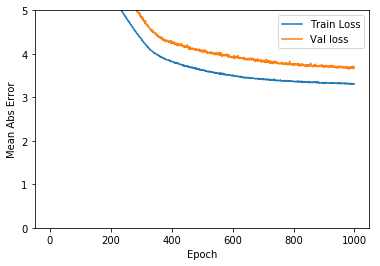

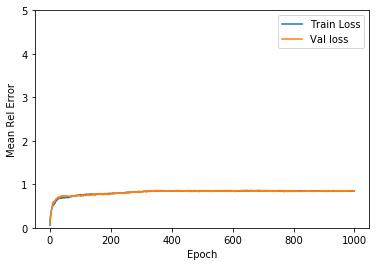

In [5]:
X,Y,Y_noise = DataGen(nobs=2000)

# Experiment with noised data

XX = np.transpose(X)
YY = np.transpose(Y_noise)

train_data,train_labels,test_data,test_labels = PrepareData(XX,YY)

model1 = build_model()

a,b,c=ML(train_data,train_labels,test_data,test_labels,model=model1,MLDEBUG=True,MLPLOTTING=True)

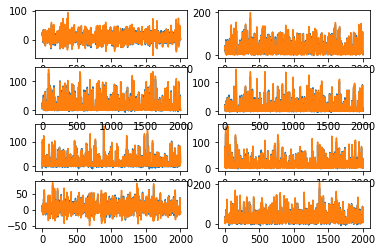

In [6]:
mean = X.T.mean(axis=0)
std = X.T.std(axis=0)

HML = MakeHML(a
              #,std,mean
             )
Y_ml = HML(X)
plt.figure()
for i in range(4):
    plt.subplot(4,2,i+1)
    plt.plot(Y_ml[i,:])
    plt.plot(Y[i,:])
    plt.subplot(4,2,i+5)
    plt.plot(Y_ml[i+10,:])
    plt.plot(Y[i+10,:])

....................................................................................................1
....................................................................................................2
....................................................................................................3
....................................................................................................4
....................................................................................................5
....................................................................................................6
....................................................................................................7
....................................................................................................8
....................................................................................................9
..................................................................................

....................................................................................................80
....................................................................................................81
....................................................................................................82
....................................................................................................83
....................................................................................................84
....................................................................................................85
....................................................................................................86
....................................................................................................87
....................................................................................................88
.........................................................................

....................................................................................................159
....................................................................................................160
....................................................................................................161
....................................................................................................162
....................................................................................................163
....................................................................................................164
....................................................................................................165
....................................................................................................166
....................................................................................................167
................................................................

(3.2241411625268297,
 4.059874626029339,
 1.5443786690996666,
 1.3529123795882656,
 3.9238772244127715,
 5.338866749545486)

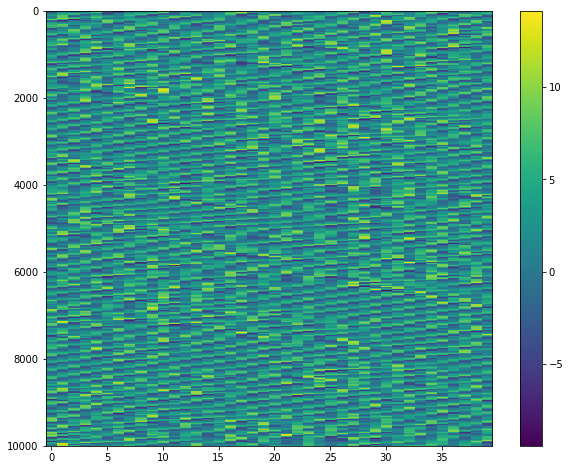

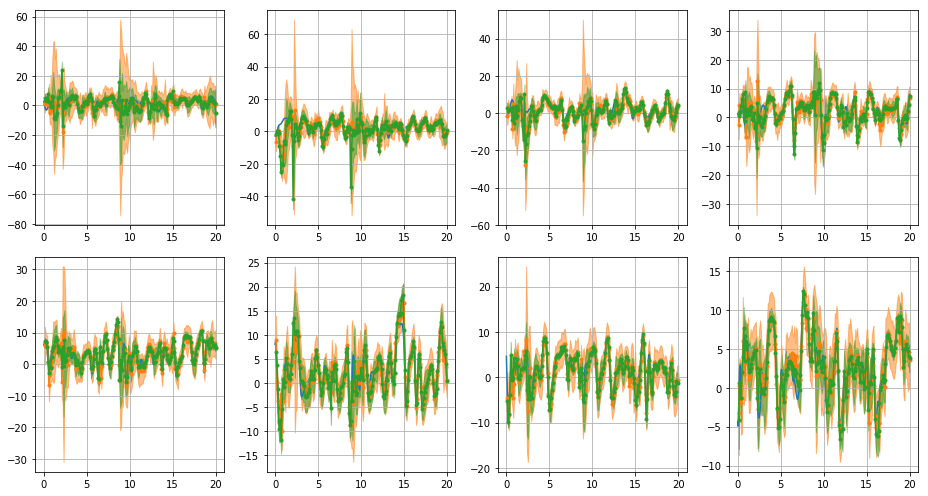

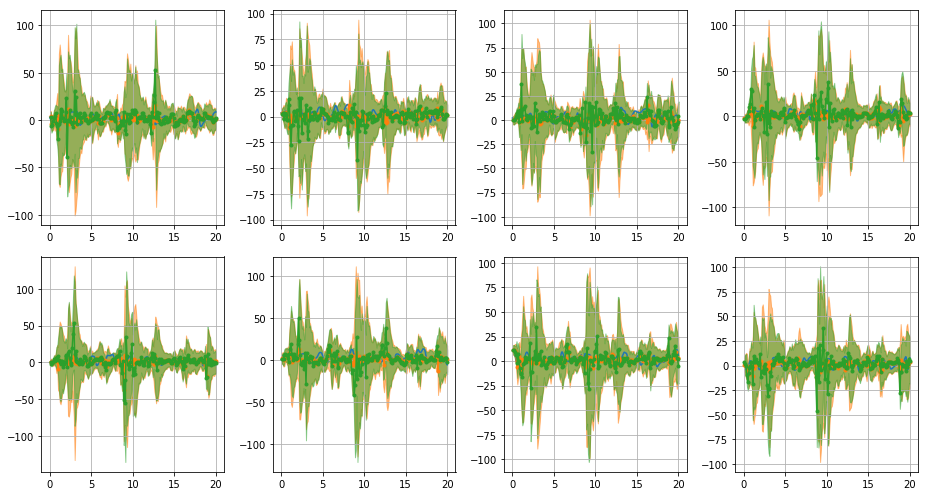

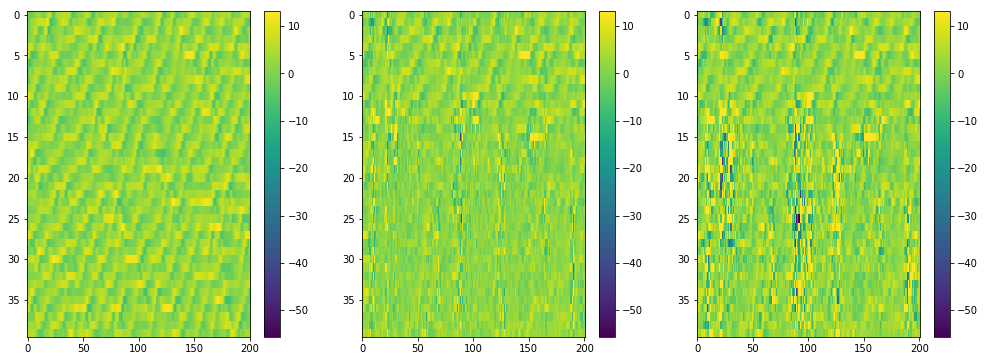

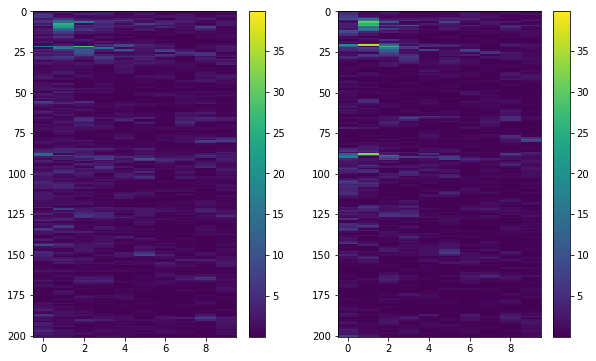

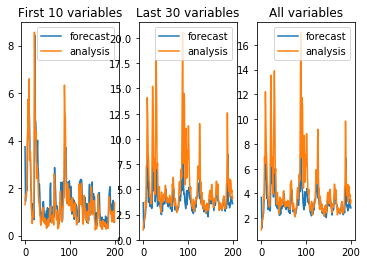

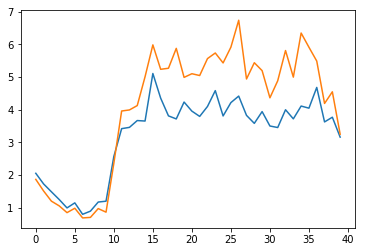

In [8]:
H = AuxFuncs.ObsOp_40_20
EnKF(#STAGE=3,truestate=X,trueobs=Y,yobs=Y_noise,
     RSEED = 1003,
     PLOTTING=True,DEBUG=True,
     HTYPE=None,HERROR=True,H=H,Hm=HML,
     dobs=20,nobs=200)